<b>Zillow Scrape and data analysis </b>

The first part will run a script that will scrape and compile the housing data into csv worksheets. The default URL which is being run is for all rental properties available in Durham. Note that apartments are excluded from being saved as most of them are not available to purchase. Only townhouses and houses are saved

In [2]:
import scrapeAndCompileHousingData

In [5]:
scrapeAndCompileHousingData.main()

starting page : 0


C:\Users\Adam\Anaconda3\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 184 of the file C:\Users\Adam\Anaconda3\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


<div class="zsg-photo-card-content zsg-aspect-ratio-content" itemscope="" itemtype="http://schema.org/SingleFamilyResidence"><span class="hide" itemprop="address" itemscope="" itemtype="http://schema.org/PostalAddress"><span itemprop="streetAddress">8022 Morrell Ln</span><span itemprop="addressLocality">Durham</span><span itemprop="addressRegion">NC</span><span class="hide" itemprop="postalCode">27713</span></span><span itemprop="geo" itemscope="" itemtype="http://schema.org/GeoCoordinates"><meta content="35.900048" itemprop="latitude"/><meta content="-78.953188" itemprop="longitude"/></span><div class="zsg-photo-card-caption"><h4 class="zsg-photo-card-spec"><span class="zsg-photo-card-status"><span class="zsg-icon-for-rent"></span>House For Rent</span></h4><p class="zsg-photo-card-spec"><span class="zsg-photo-card-price">$1,995/mo</span><span class="zsg-photo-card-info">4 bds <span class="interpunct">·</span> 3 ba <span class="interpunct">·</span> 2,750 sqft</span></p><p class="zsg-ph

KeyboardInterrupt: 

Currently a number of csv sheets have been saved based on information using the Zillow API.

<b>Data Visualization: price</b>

In [126]:
import pandas as pd
import numpy
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pandas.stats.api import ols

In [127]:

house_data = pd.read_csv('allDurhamData.csv', index_col=0, thousands=',')
house_data.head(3)

,city,zipcode,address,zpid,bathrooms,bedrooms,sqft,hometype,zestimate,rentzestimate,real rent
state,,,,,,,,,,,
NC,Durham,27704,2504 Shenandoah Ave APT B,2108319611,1.0,1,570,Townhouse,186920.0,895,895
NC,Durham,27713,200 W Woodcroft Pkwy APT 54B,50000827,2.0,2,1000,Townhouse,128235.0,1215,1350
NC,Durham,27704,700 E Ellerbee St,49981022,1.0,2,672,SingleFamily,82677.0,925,949


In [128]:
X = house_data[['bedrooms', 'bathrooms', 'sqft']]
house_price = house_data['zestimate']
house_rent = house_data['real rent']
house_price_rent_ratio = house_rent / house_price
sortedByBedrooms = [];
numBedrooms = [];
#This for loop is here to sort the bedroom data into lists based on number of bedrooms
for i in sorted(house_data.bedrooms.unique()):
    numBedrooms.append(i)
    valList = numpy.array(list(house_data.zestimate[list(house_data.bedrooms == i)]))
    valList = valList[~numpy.isnan(valList)]
    sortedByBedrooms.append(valList)

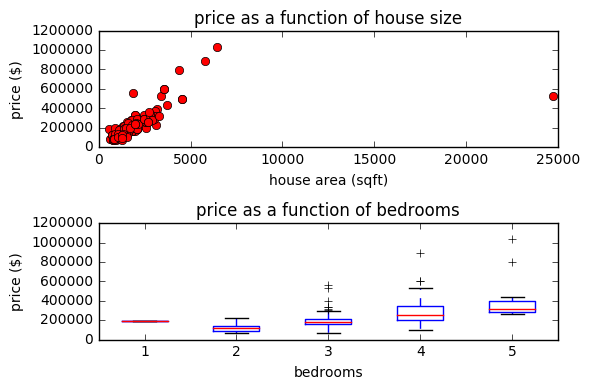

In [129]:
plt.subplot(2,1,1)
plt.plot(X['sqft'], house_price, 'ro')
plt.xlabel('house area (sqft)')
plt.ylabel('price ($)')
plt.title('price as a function of house size')
plt.subplot(2,1,2)
plt.boxplot(sortedByBedrooms)
plt.xlabel('bedrooms')
plt.ylabel('price ($)')
plt.title('price as a function of bedrooms')
plt.xticks(numBedrooms)
plt.tight_layout()
plt.show()

From the figures above we can see that 1 bedroom houses might need to be culled as well as the house with the way more square footage than comparable houses

In [202]:
mask = numpy.array(X['sqft']<15000) & numpy.array(X['bedrooms']>1) & numpy.array(house_price>1)

In [164]:
X = X[mask]
house_price = house_price[mask]
house_rent = house_rent[mask]
house_price_rent_ratio = house_price_rent_ratio[mask]
house_data = house_data[mask]

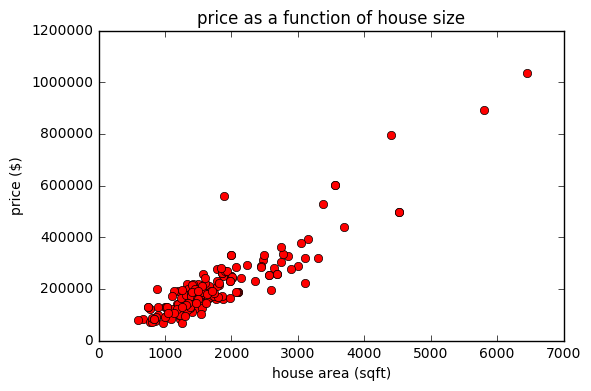

In [165]:
plt.plot(X['sqft'], house_price, 'ro')
plt.xlabel('house area (sqft)')
plt.ylabel('price ($)')
plt.title('price as a function of house size')
plt.show()

The house price per sqft looks better and more linear with outlier removed

Normalizing data before fitting a linear regression curve

In [166]:
for column_name in X.keys():
    house_data[column_name + '_norm'] = (X[column_name] - numpy.mean(X[column_name])) / numpy.std(X[column_name])

In [171]:
Xnorm = house_data[['bedrooms_norm', 'bathrooms_norm', 'sqft_norm']]

In [186]:
est = sm.OLS(house_price, Xnorm).fit()

In [187]:
est.params

bedrooms_norm     -20722.886682
bathrooms_norm     -3601.303201
sqft_norm         137120.685289
dtype: float64

The results above are really weird... it would appear that house price goes down with increasing bedrooms and bathrooms. This could indicate that a large house with fewer bedrooms is worth more than a small house with more bedrooms... 

In [201]:
estSingle = sm.OLS(house_price, Xnorm['sqft_norm']).fit()
print(estSingle.params)
estSingle = sm.OLS(house_price, Xnorm['bedrooms_norm']).fit()
print(estSingle.params)
estSingle = sm.OLS(house_price, Xnorm['bathrooms_norm']).fit()
print(estSingle.params)

sqft_norm    119955.319414
dtype: float64
bedrooms_norm    75409.099613
dtype: float64
bathrooms_norm    73674.095563
dtype: float64


Above is a sanity check to ensure that each individual parameter acts as we would expect individually

<b>Data Visualization: price to rent</b>

In [219]:
sortedByBedrooms = [];
numBedrooms = [];
for i in sorted(house_data.bedrooms.unique()):
    numBedrooms.append(i)
    valList = numpy.array(list(house_price_rent_ratio[list(house_data.bedrooms == i)]))
    valList = valList[~numpy.isnan(valList)]
    sortedByBedrooms.append(valList)

In [241]:
numBedrooms

[2, 3, 4, 5]

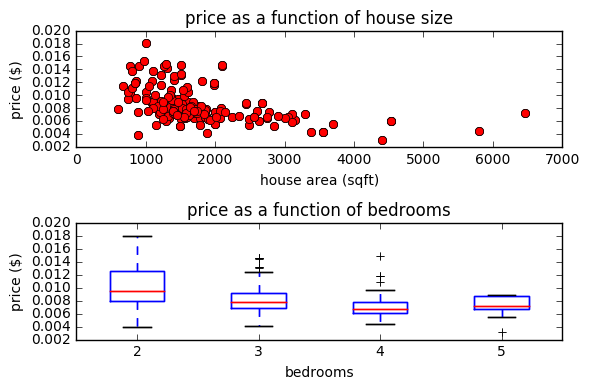

In [246]:
plt.subplot(2,1,1)
plt.plot(X['sqft'], house_price_rent_ratio, 'ro')
plt.xlabel('house area (sqft)')
plt.ylabel('price ($)')
plt.title('price as a function of house size')
plt.subplot(2,1,2)
plt.boxplot(sortedByBedrooms)
plt.xticks(range(1,5), numBedrooms)
plt.xlabel('bedrooms')
plt.ylabel('price ($)')
plt.title('price as a function of bedrooms')

plt.tight_layout()
plt.show()

From the figures above it seems as though we can see a weak trend that would indicate that for a rent/price ratio. It looks as though a smaller, fewer bedrooms will results in best rent returns